In [1]:
module VREP

export simx_start,
    simx_finish,
    simx_get_object_handle,
    simx_get_string_signal,
    simx_unpack_floats,
    simx_get_vision_sensor_image,
    simx_get_object_position,
    simx_get_object_orientation,
    simx_set_joint_target_velocity,
    simx_opmode_oneshot_wait,
    simx_opmode_streaming,
    simx_return_ok


simx_opmode_oneshot_wait = 0x010000
simx_opmode_streaming    = 0x020000
simx_opmode_buffer       = 0x060000

simx_return_ok = 0x000000


import Libdl

lib = Libdl.dlopen("./remoteApi.so")
simx_start_fn = Libdl.dlsym(lib, :simxStart)
simx_finish_fn = Libdl.dlsym(lib, :simxFinish)
simx_get_object_handle_fn = Libdl.dlsym(lib, :simxGetObjectHandle)
simx_read_proximity_sensor_fn = Libdl.dlsym(lib, :simxReadProximitySensor)
simx_get_string_signal_fn = Libdl.dlsym(lib, :simxGetStringSignal)
simx_get_vision_sensor_image_fn = Libdl.dlsym(lib, :simxGetVisionSensorImage)
simx_get_object_position_fn = Libdl.dlsym(lib, :simxGetObjectPosition)
simx_get_object_orientation_fn = Libdl.dlsym(lib, :simxGetObjectOrientation)
simx_set_joint_target_velocity_fn = Libdl.dlsym(lib, :simxSetJointTargetVelocity)
simx_start_simulation_fn = Libdl.dlsym(lib, :simxStartSimulation)
simx_stop_simulation_fn = Libdl.dlsym(lib, :simxStopSimulation)

function simx_start(connection_address, connection_port, wait_until_connected,
        do_dot_reconnect_once_disconnected, timeout_in_ms, comm_thread_cycle_in_ms)
    client_id = ccall(simx_start_fn, Cint, (Cstring, Cint, Cuchar, Cuchar, Cint, Cint),
        connection_address, connection_port, wait_until_connected,
        do_dot_reconnect_once_disconnected, timeout_in_ms, comm_thread_cycle_in_ms)
    return client_id
end

function simx_finish(client_id)
    ccall(simx_finish_fn, Cvoid, (Cint,), client_id)
    return nothing
end

function simx_get_object_handle(client_id, object_name, operation_mode)
    handle = Ref{Cint}(0)
    ret = ccall(simx_get_object_handle_fn, Cint, (Cint, Cstring, Ref{Cint}, Cint),
        client_id, object_name, handle, operation_mode)
    return ret, handle[]
end

function simx_read_proximity_sensor(client_id, sensor_handle, operation_mode)
    detection_state = Ref{Cuchar}(0)
    detected_object_handle = Ref{Cint}(0)
    detected_point = Vector{Cfloat}(undef, 3)
    detected_surface_normal_vector = Vector{Cfloat}(undef, 3)
    ret = ccall(simx_read_proximity_sensor_fn, Cint, (Cint, Cint, Ref{Cuchar}, Ref{Cfloat}, Ref{Cint}, Ref{Cfloat}, Cint),
        client_id, sensor_handle, detection_state, detected_point, detected_object_handle, detected_surface_normal_vector, operation_mode)
    return ret, detection_state[] != 0, detected_point, detected_object_handle[], detected_surface_normal_vector
end

function simx_get_string_signal(client_id, signal_name, operation_mode)
    signal_length = Ref{Cint}(0)
    signal_value = Ref{Ptr{Cuchar}}()
    ret = ccall(simx_get_string_signal_fn, Cint, (Cint, Cstring, Ref{Ptr{Cuchar}}, Ref{Cint}, Cint),
        client_id, signal_name, signal_value, signal_length, operation_mode)
    signal_str = unsafe_string(signal_value[], signal_length[])
    return ret, signal_str
end

function simx_unpack_floats(floats_packed_in_string)
    v = Vector{Float32}(undef, 0)
    data = Vector{UInt8}(floats_packed_in_string)
    for i=1:4:length(data)
        n = reinterpret(Float32, data[i:i+3])[1]
        push!(v, n)
    end
    return v
end

function simx_get_vision_sensor_image(client_id, sensor_handle, options, operation_mode)
    resolution = Vector{Cint}(undef, 2)
    image_raw = Ref{Ptr{Cuchar}}()
    bytes_per_pixel = 3
    if (options & 1) != 0
        bytes_per_pixel = 1
    end
    ret = ccall(simx_get_vision_sensor_image_fn, Cint, (Cint, Cint, Ref{Cint}, Ref{Ptr{Cuchar}}, Cuchar, Cint),
        client_id, sensor_handle, resolution, image_raw, options, operation_mode)
    if ret != simx_return_ok
        return ret, resolution, Vector{UInt8}(undef, 0)
    end
    image_data = Vector{UInt8}(undef, resolution[1] * resolution[2] * bytes_per_pixel)
    for i=1:length(image_data)
        image_data[i] = unsafe_load(image_raw[], i)
    end
    return ret, resolution, image_data
end

function simx_get_object_position(client_id, object_handle, relative_to_object_handle, operation_mode)
    position = Vector{Cfloat}(undef, 3)
    ret = ccall(simx_get_object_position_fn, Cint, (Cint, Cint, Cint, Ref{Cfloat}, Cint),
        client_id, object_handle, relative_to_object_handle, position, operation_mode)
    return ret, position
end

function simx_get_object_orientation(client_id, object_handle, relative_to_object_handle, operation_mode)
    euler_angles = Vector{Cfloat}(undef, 3)
    ret = ccall(simx_get_object_orientation_fn, Cint, (Cint, Cint, Cint, Ref{Cfloat}, Cint),
        client_id, object_handle, relative_to_object_handle, euler_angles, operation_mode)
    return ret, euler_angles
end

function simx_set_joint_target_velocity(client_id, joint_handle, target_velocity, operation_mode)
    ret = ccall(simx_set_joint_target_velocity_fn, Cint, (Cint, Cint, Cfloat, Cint),
        client_id, joint_handle, target_velocity, operation_mode)
    return ret
end

function simx_start_simulation(client_id, operation_mode)
    ret = ccall(simx_start_simulation_fn, Cint, (Cint, Cint),
        client_id, operation_mode)
    return ret
end

function simx_stop_simulation(client_id, operation_mode)
    ret = ccall(simx_stop_simulation_fn, Cint, (Cint, Cint),
        client_id, operation_mode)
    return ret
end

end # module VREP

Main.VREP

In [2]:
function start_sim(connection_address, connection_port)
    VREP.simx_finish(-1)
    client_id = VREP.simx_start(connection_address, connection_port, true, true, 2000, 5)
    if client_id != -1
        println("Connected to remoteApi server.")
    else
        VREP.simx_finish(-1)
        error("Unable to connect to remoteApi server. Consider running scene before executing script.")
    end
    return client_id
end

function start_sensors(client_id)
    # Starting ultrasonic sensors
    us_handle = Vector{Int}(undef, 16)
    for i=1:16
        sensor_name = string("Pioneer_p3dx_ultrasonicSensor", i)

        res, handle = VREP.simx_get_object_handle(client_id, sensor_name, VREP.simx_opmode_oneshot_wait)
        if res != VREP.simx_return_ok
            println(sensor_name, " not connected.")
        else
            println(sensor_name, " connected.")
            us_handle[i] = handle
        end
    end

    #Starting vision sensor
    res, vision_handle = VREP.simx_get_object_handle(client_id, "Vision_sensor", VREP.simx_opmode_oneshot_wait)
    if res != VREP.simx_return_ok
        println("Vision sensor not connected.")
    else
        println("Vision sensor connected.")
    end
    
    #Starting laser sensor
    res, laser_handle = VREP.simx_get_object_handle(client_id, "fastHokuyo", VREP.simx_opmode_oneshot_wait)
    if res != VREP.simx_return_ok
        println("Laser not connected.")
    else
        println("Laser connected.")
    end
    
    return us_handle, vision_handle, laser_handle
end

function start_motors(client_id)
    res, left_handle = VREP.simx_get_object_handle(client_id, "Pioneer_p3dx_leftMotor", VREP.simx_opmode_oneshot_wait)
    if res != VREP.simx_return_ok
        println("Left motor not connected.")
    else
        println("Left motor connected.")
    end
    
    res, right_handle = VREP.simx_get_object_handle(client_id, "Pioneer_p3dx_rightMotor", VREP.simx_opmode_oneshot_wait)
    if res != VREP.simx_return_ok
        println("Right motor not connected.")
    else
        println("Right motor connected.")
    end
    
    return Dict(:left => left_handle, :right => right_handle)
end

function start_robot(client_id)
    res, robot_handle = VREP.simx_get_object_handle(client_id, "Pioneer_p3dx", VREP.simx_opmode_oneshot_wait)
    if res != VREP.simx_return_ok
        println("Robot not connected.")
    else
        println("Robot connected.")
    end
    
    return robot_handle
end

SERVER_IP = "127.0.0.1"
SERVER_PORT = 19997

ROBOT_WIDTH = 0.381
WHEEL_RADIUS = 0.195/2.0

client_id = start_sim(SERVER_IP, SERVER_PORT)

@show(client_id)

us_handle, vision_handle, laser_handle = start_sensors(client_id)

@show(us_handle)

@show(vision_handle)

@show(laser_handle)

motors_handle = start_motors(client_id)

@show(motors_handle)

robot_handle = start_robot(client_id)

@show(robot_handle)

nothing

Connected to remoteApi server.
client_id = 0
Pioneer_p3dx_ultrasonicSensor1 connected.
Pioneer_p3dx_ultrasonicSensor2 connected.
Pioneer_p3dx_ultrasonicSensor3 connected.
Pioneer_p3dx_ultrasonicSensor4 connected.
Pioneer_p3dx_ultrasonicSensor5 connected.
Pioneer_p3dx_ultrasonicSensor6 connected.
Pioneer_p3dx_ultrasonicSensor7 connected.
Pioneer_p3dx_ultrasonicSensor8 connected.
Pioneer_p3dx_ultrasonicSensor9 connected.
Pioneer_p3dx_ultrasonicSensor10 connected.
Pioneer_p3dx_ultrasonicSensor11 connected.
Pioneer_p3dx_ultrasonicSensor12 connected.
Pioneer_p3dx_ultrasonicSensor13 connected.
Pioneer_p3dx_ultrasonicSensor14 connected.
Pioneer_p3dx_ultrasonicSensor15 connected.
Pioneer_p3dx_ultrasonicSensor16 connected.
Vision sensor connected.
Laser connected.
us_handle = [328, 327, 326, 325, 324, 323, 322, 321, 336, 335, 334, 333, 332, 331, 330, 329]
vision_handle = 355
laser_handle = 348
Left motor connected.
Right motor connected.
motors_handle = Dict(:left => 311,:right => 308)
Robot co

In [3]:
function read_ultrasonic_sensors(client_id, us_handle)
    distances = Vector{Float32}(undef, length(us_handle))
    no_detection_dist = 5.0 # Here we define the maximum distance as 5 meters

    for (i, sensor) in enumerate(us_handle)
        res, status, distance, _, _ = VREP.simx_read_proximity_sensor(client_id, sensor, VREP.simx_opmode_streaming)
        while res != VREP.simx_return_ok
            res, status, distance, _, _ = VREP.simx_read_proximity_sensor(client_id, sensor, VREP.simx_opmode_buffer)
        end
        distances[i] = status != 0 ? distance[3] : no_detection_dist
    end

    return distances
end

sonar_data = read_ultrasonic_sensors(client_id, us_handle)

@show(sonar_data)

nothing

sonar_data = Float32[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 0.5873817, 0.45877215, 0.44481668, 5.0, 5.0, 5.0, 5.0]


In [4]:
function read_laser(client_id, laser_handle)
    res, laser = VREP.simx_get_string_signal(client_id, "LasermeasuredDataAtThisTime", VREP.simx_opmode_streaming)
    while res != VREP.simx_return_ok
        res, laser = VREP.simx_get_string_signal(client_id, "LasermeasuredDataAtThisTime", VREP.simx_opmode_buffer)
    end

    return VREP.simx_unpack_floats(laser)
end

laser_data = read_laser(client_id, laser_handle)

@show(laser_data)

println(length(laser_data))

nothing

laser_data = Float32[-2.4149826, -4.182872, 0.063000165, -2.3828197, -4.186334, 0.063000165, -2.3512163, -4.1904707, 0.063000165, -2.310894, -4.1785393, 0.063000165, -2.280389, -4.1838527, 0.063000165, -2.2503757, -4.189822, 0.063000165, -2.2117915, -4.179362, 0.063000165, -2.1827416, -4.1864643, 0.063000165, -2.1452081, -4.1768546, 0.063000165, -2.1170778, -4.185136, 0.063000165, -2.0805483, -4.17641, 0.063000165, -2.053189, -4.1857066, 0.063000165, -2.0176218, -4.1779037, 0.063000165, -1.9909986, -4.1882706, 0.06300017, -1.9562877, -4.1812916, 0.06300017, -1.922001, -4.174616, 0.06300017, -1.8963772, -4.186458, 0.06300017, -1.8628813, -4.1806393, 0.06300017, -1.8297622, -4.1751013, 0.06300017, -1.8050342, -4.1884637, 0.06300017, -0.8126837, -1.9181075, 0.06300008, -0.7979712, -1.9160599, 0.06300008, -0.78344697, -1.9142276, 0.06300008, -0.77253973, -1.9211532, 0.06300008, -0.7582521, -1.9195993, 0.06300008, -0.7441148, -1.918206, 0.06300008, -0.7301097, -1.9169384, 0.06300008, -0.716

In [5]:
function read_vision_sensor(client_id, vision_handle)
    res, resolution, image_data = VREP.simx_get_vision_sensor_image(client_id, vision_handle, 0, VREP.simx_opmode_streaming)
    while res != VREP.simx_return_ok
        res, resolution, image_data = VREP.simx_get_vision_sensor_image(client_id, vision_handle, 0, VREP.simx_opmode_buffer)
    end
    return resolution, image_data
end

vision_data = read_vision_sensor(client_id, vision_handle)

@show(vision_data[1])

nothing

vision_data[1] = Int32[256, 256]


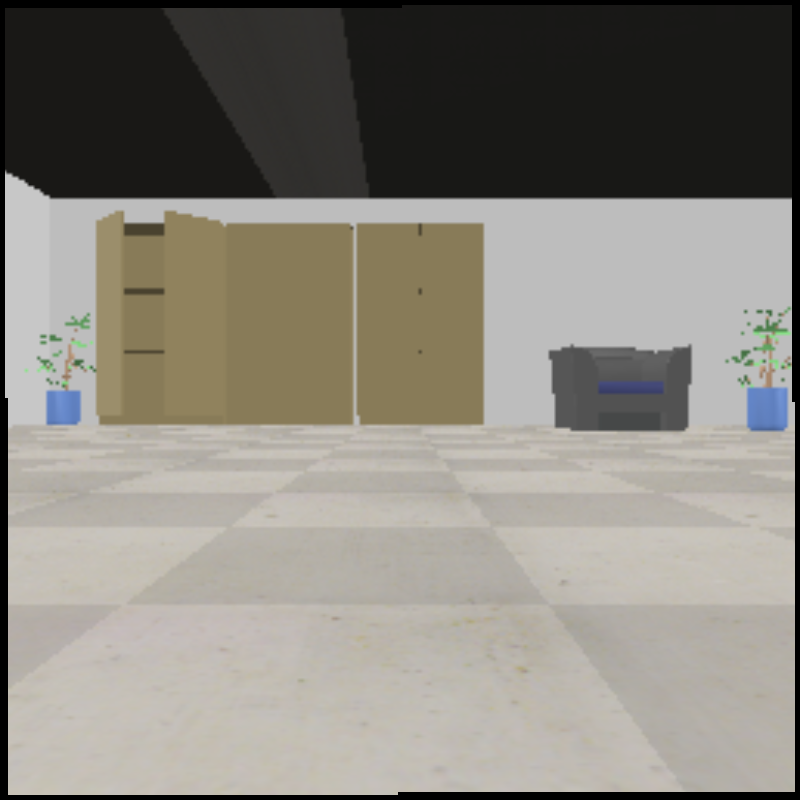

In [6]:
using Images

resolution, image_data = vision_data
image = imrotate(colorview(RGB, reshape(Float64.(image_data) / 255, 3, Int64.(resolution)...)), 3π/2)

imresize(image, 800, 800)

In [7]:
function get_current_position(client_id, robot_handle)
    res, position = VREP.simx_get_object_position(client_id, robot_handle, -1, VREP.simx_opmode_streaming)
    while res != VREP.simx_return_ok
        res, position = VREP.simx_get_object_position(client_id, robot_handle, -1, VREP.simx_opmode_buffer)
    end
    return position
end

function get_current_orientation(client_id, robot_handle)
    res, orientation = VREP.simx_get_object_orientation(client_id, robot_handle, -1, VREP.simx_opmode_streaming)
    while res != VREP.simx_return_ok
        res, orientation = VREP.simx_get_object_orientation(client_id, robot_handle, -1, VREP.simx_opmode_buffer)
    end
    return orientation
end

position = get_current_position(client_id, robot_handle)

orientation = get_current_orientation(client_id, robot_handle)

@show(position)

@show(orientation)

nothing

position = Float32[-2.0266392, -0.82501686, 0.13868067]
orientation = Float32[-7.642689e-5, -0.0020217896, -0.0003149158]


In [8]:
function set_right_velocity(client_id, motors_handle, velocity)
	VREP.simx_set_joint_target_velocity(client_id, motors_handle[:right], velocity, VREP.simx_opmode_streaming)
end

function set_left_velocity(client_id, motors_handle, velocity)
	VREP.simx_set_joint_target_velocity(client_id, motors_handle[:left], velocity, VREP.simx_opmode_streaming)
end

function set_velocity(client_id, motors_handle, linear_velocity, angular_velocity)
    left_velocity = (linear_velocity - angular_velocity * (ROBOT_WIDTH / 2)) / WHEEL_RADIUS
    right_velocity = (linear_velocity + angular_velocity * (ROBOT_WIDTH / 2)) / WHEEL_RADIUS
    set_left_velocity(client_id, motors_handle, left_velocity)
    set_right_velocity(client_id, motors_handle, right_velocity)
end

function stop(client_id, motors_handle)
    set_velocity(client_id, motors_handle, 0, 0)
	sleep(0.1)
end

p0 = get_current_position(client_id, robot_handle)
a0 = get_current_orientation(client_id, robot_handle)

@show(p0)
@show(a0)

set_velocity(client_id, motors_handle, 0.1, 0)

sleep(5)

stop(client_id, motors_handle)

p1 = get_current_position(client_id, robot_handle)
a1 = get_current_orientation(client_id, robot_handle)

@show(p1)
@show(a1)

nothing

p0 = Float32[-2.026651, -0.8250189, 0.13867956]
a0 = Float32[-7.0456816e-5, -0.0020199916, -0.0003094755]
p1 = Float32[-1.5302418, -0.82528526, 0.13868794]
a1 = Float32[-5.1090876e-5, -0.0018254106, -0.00044299715]


In [9]:
function reset(client_id, motors_handle)
    stop(client_id, motors_handle)
    res = VREP.simx_stop_simulation(client_id, VREP.simx_opmode_oneshot_wait)
    if res == VREP.simx_return_ok
        println("Simulation stopped...")
        sleep(1.0)
    end
    n = 0
    while true
        n += 1
        res = VREP.simx_start_simulation(client_id, VREP.simx_opmode_oneshot_wait)
        if res == VREP.simx_return_ok
            println("Simulation started...")
            break
        end
        sleep(1.0)
        if n == 10
            println("Failed to start simulation!")
            break
        end
        println("Retry $n")
    end
end

p0 = get_current_position(client_id, robot_handle)
a0 = get_current_orientation(client_id, robot_handle)

@show(p0)
@show(a0)

reset(client_id, motors_handle)

p1 = get_current_position(client_id, robot_handle)
a1 = get_current_orientation(client_id, robot_handle)

@show(p1)
@show(a1)

nothing

p0 = Float32[-1.5052029, -0.8252926, 0.1386981]
a0 = Float32[-7.7792196e-5, -0.0015176922, -0.00044194987]
Simulation stopped...
Retry 1
Simulation started...
p1 = Float32[-2.0252814, -0.8249877, 0.13867705]
a1 = Float32[-8.340267e-5, -0.001994907, -1.4512913e-5]
